In [19]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#imports for visualisations
import matplotlib.pyplot as plt

# importing libraries for NLP
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#importing libraries for modelling
import sklearn.metrics as metrics
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from scipy.spatial.distance import correlation
import os
import json

In [20]:
# import transformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import unidecode

import re
import nltk
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Import evaluation metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from scipy import stats 
from scipy.stats import kurtosis,skew

In [21]:
print(os.getcwd())
os.chdir(r"C:\Users\User\Desktop\ga_class\capstone\part_01\yelp")
print(os.getcwd())

C:\Users\User\Desktop\ga_class\capstone\part_01\yelp
C:\Users\User\Desktop\ga_class\capstone\part_01\yelp


In [22]:
def load_file(name_file,quantity):
    file_name =  'yelp_academic_dataset_'+ str(name_file) + '.json'
    ifile = open(file_name,encoding = 'cp866') 
    stop = quantity

    all_data = list()
    for i, line in enumerate(ifile):
        if i==stop:
            break    
        # convert the json on this line to a dict
        data = json.loads(line)
        # add to the data collected so far
        all_data.append(data)
    # create the DataFrame
    df = pd.DataFrame(all_data)
    # df.to_hdf('revie20ws.h5','reviews')
    ifile.close()
    return df

In [23]:
business = load_file('business',2000000)
review = load_file('review',2000000)

In [24]:
business.shape,review.shape 

((150346, 14), (2000000, 9))

# 1. Preprocessing Business EDA  

In [25]:
business = business.drop(columns = ['address','postal_code','latitude','longitude','hours'])

In [26]:
business['categories'] = business['categories'].fillna('Unknown')

In [27]:
# create function to transform string as list with split between comma
import re
def split_categories(x):
    s = re.split(r'[,;!&]', x)
    return s

In [28]:
# change each row from string to list
business.categories = business.categories.map(split_categories)

In [29]:
#check duplicate entry for business_id
# there is no duplicate entry
business.business_id.describe()

count                     150346
unique                    150346
top       Pns2l4eNsfO8kk83dixA6A
freq                           1
Name: business_id, dtype: object

In [30]:
# create a summary of each row category
list_append=[]
for i in business.categories:
    for j in i:
        list_append.append(j)
        break

In [32]:
# create new feature
business['summary_category'] = list_append

In [163]:
business.head(3)

,business_id,name,city,state,stars,review_count,is_open,attributes,categories,summary_category
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara,CA,5.0,7,0,{'ByAppointmentOnly': 'True'},"[Doctors, Traditional Chinese Medicine, Natu...",Doctors
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"[Shipping Centers, Local Services, Notaries,...",Shipping Centers
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","[Department Stores, Shopping, Fashion, Home...",Department Stores


In [170]:
# save cleaned business df
# business.to_csv('business_clean.csv',index=False)

## 1.1 Create refer_business df

In [34]:
# creating a dataframe to store all the records which has 'Restaurants' or 'Food' in their categories column
# dataframe name is 'b'
b = pd.DataFrame()
for i in business.index:
    if 'Restaurants' in business.categories[i] or 'Food' in business.categories[i]:
        b = b.append(business.iloc[i])

In [35]:
#create dataframe to indicate temporary use
business_category_to_substitute = b
business_rest_or_food_only = b

In [36]:
#create dataframe to refer for recommender systems
# refer business df contain basic info of business dataframe and the business summary's category
refer_business = business[['business_id']]
refer_business['business_name'] = business['name']

In [37]:
refer_business['summary_category'] = business['summary_category']

In [38]:
refer_business.shape

(150346, 3)

In [39]:
refer_business.head()

,business_id,business_name,summary_category
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Doctors
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Shipping Centers
2,tUFrWirKiKi_TAnsVWINQQ,Target,Department Stores
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Restaurants
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Brewpubs


In [40]:
#create new feature that help indicate this df only contain restaurant's business
business_rest_or_food_only['label'] = 'restaurant'
business_rest_food_df = business_rest_or_food_only[['business_id']]
business_rest_food_df['label'] = business_rest_or_food_only['label']

In [41]:
#this df is only temporarily created to merge with refer_business df
# this is done as not all business id is in this df to direct concat
business_rest_food_df.head(1)

,business_id,label
3,MTSW4McQd7CbVtyjqoe9mw,restaurant


In [42]:
# finalize refer business df
# fill NaN as non restaurant
refer_business = pd.merge(refer_business,business_rest_food_df,on='business_id',how='outer')
refer_business.label.fillna('non_restaurant',inplace=True)

In [43]:
refer_business.head(1)

,business_id,business_name,summary_category,label
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Doctors,non_restaurant


In [41]:
#save backup of refer business dataframe
# refer_business.to_csv('refer_business.csv',index=False)
# business_rest_or_food_only.to_csv('business_rest_or_food_only.csv',index=False)

In [42]:
#  load this instead of rerun everything
# refer_business = pd.read_csv('refer_business.csv')
# business_rest_or_food_only = pd.read_csv('business_rest_or_food_only.csv')

## 1.2 Unpack attributes column

### 1.2.1 Create attributes_df

In [44]:
attributes_df = []

In [45]:
# make attributes features' subvalues as columns
attributes_df = business_rest_or_food_only[['attributes']]
attributes_df = attributes_df.join(pd.DataFrame(attributes_df['attributes'].to_dict()).T)

In [46]:
attributes_df.head(1)

,attributes,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,ByAppointmentOnly,WiFi,...,CoatCheck,BestNights,Smoking,BYOBCorkage,Corkage,Open24Hours,AgesAllowed,DietaryRestrictions,RestaurantsCounterService,AcceptsInsurance
3,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",False,False,False,"{'garage': False, 'street': True, 'validated':...",True,1,True,False,u'free',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
attributes_df.drop(columns = ['attributes'],inplace=True)

In [48]:
#store columns in a list
columns = attributes_df.columns.values.tolist()

In [49]:
import ast

#define function to change each row attributes from string to dictionary
def turn_json_dict(x):
    try:
        x = ast.literal_eval(x)
        return x
    except:pass
    
# create dummy kind of function to make each subvalues attributes as different unique columns
def dummy_dict(dataframe,column):
    df = dataframe[[column]]
    df[column] = df[column].map(turn_json_dict)
    df = df[column].apply(pd.Series)
    return df

In [50]:
# check value in each columns of attributes
for col in attributes_df.columns:
    print(col)
    print(attributes_df[col].value_counts())
    print('\n')

RestaurantsDelivery
True     10718
False     6569
None       942
Name: RestaurantsDelivery, dtype: int64


OutdoorSeating
False    8235
True     6937
None      615
Name: OutdoorSeating, dtype: int64


BusinessAcceptsCreditCards
True     18324
False      710
None        13
Name: BusinessAcceptsCreditCards, dtype: int64


BusinessParking
{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}         7358
{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}        4672
{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}         2895
{'garage': False, 'street': True, 'validated': False, 'lot': True, 'valet': False}           947
None                                                                                         323
                                                                                            ... 
{'garage': True, 'street': True, 'validated': False, 'lot': None, 'valet': False

In [171]:
# #save attributes_df
# attributes_df.to_csv('attributes_df.csv',index=False)

### 1.2.2 Create business2 df

In [53]:
# create temporary df for attributes
# this new df is use to create dummy columns from attributes df
business2 = attributes_df

In [54]:
df_biz_parking = dummy_dict(business2,'BusinessParking')
df_alcohol = dummy_dict(business2,'Alcohol')
df_restaurant_attire = dummy_dict(business2,'RestaurantsAttire')

In [55]:
df_ambience = dummy_dict(business2,'Ambience')
df_good_meal = dummy_dict(business2,'GoodForMeal')
df_noise_level = dummy_dict(business2,'NoiseLevel')

In [56]:
df_smoking = dummy_dict(business2,'Smoking')
df_music = dummy_dict(business2,'Music')
df_best_night = dummy_dict(business2,'BestNights')

In [57]:
df_wifi = dummy_dict(business2,'WiFi')
df_Byob_Corkage = dummy_dict(business2,'BYOBCorkage')
df_Dietary_Restrictions = dummy_dict(business2,'DietaryRestrictions')

In [58]:
#create empty dataframe 
datas = []
df = pd.DataFrame(datas)

In [59]:
df.head(1)

""


In [60]:
#initialize,assign,merge and rename respective columns that haas been dummified 
df = df_biz_parking
df = pd.merge(df,df_alcohol,on=df.index, how = 'left')
df.rename(columns={0:'Alcohol'},inplace=True)
df.drop(columns=['key_0'],inplace=True)
df = pd.merge(df,df_restaurant_attire,on=df.index, how = 'left')
df.rename(columns={0:'rest_Attire'},inplace=True)
df.drop(columns=['key_0'],inplace=True)
df = pd.merge(df,df_ambience,on=df.index, how = 'left')
df.drop(columns=['key_0'],inplace=True)
df = pd.merge(df,df_good_meal,on=df.index, how = 'left')
df.drop(columns=['key_0'],inplace=True)
df = pd.merge(df,df_noise_level,on=df.index, how = 'left')
df.rename(columns={0:'noise_level'},inplace=True)
df.drop(columns=['key_0'],inplace=True)
df = pd.merge(df,df_smoking,on=df.index, how = 'left')
df.rename(columns={0:'smoking'},inplace=True)
df.drop(columns=['key_0'],inplace=True)
df = pd.merge(df,df_music,on=df.index, how = 'left')
df.drop(columns=['key_0'],inplace=True)
df = pd.merge(df,df_best_night,on=df.index, how = 'left')
df.drop(columns=['key_0'],inplace=True)
df = pd.merge(df,df_wifi,on=df.index, how = 'left')
df.rename(columns = {0:'Wifi'},inplace=True)
df.drop(columns=['key_0'],inplace=True)
df = pd.merge(df,df_Byob_Corkage,on=df.index, how = 'left')
df.rename(columns = {0:'ByOB_Corkage'},inplace=True)
df.drop(columns=['key_0'],inplace=True)
df = pd.merge(df,df_Dietary_Restrictions,on=df.index, how = 'left')
df.rename(columns = {0:'Dietary_Restrictions'},inplace=True)
df.drop(columns=['key_0'],inplace=True)

In [61]:
#create column to be dropped
# this columns already dummified
columns = ['BusinessParking','Alcohol','RestaurantsAttire','Ambience','GoodForMeal','NoiseLevel','Smoking','Music','WiFi',
           'BYOBCorkage','BestNights','BYOBCorkage','DietaryRestrictions']

In [62]:
# drop the aforementioned columns
business2.drop(columns = columns,inplace = True)

In [63]:
# combine all dummy columns to a dataframe,new_cat
to_dummy = business2.columns.values.tolist()
new_cat = pd.concat([pd.get_dummies(business2[col], prefix=col, prefix_sep='_') for col in to_dummy], axis=1)

In [64]:
# realign index 
index_actual = business2.index.tolist()
df.index = index_actual

### 1.2.3 Create all_attributes df

In [66]:
all_attributes = pd.concat([df, new_cat], axis=1)
business2 = pd.concat([business2, all_attributes], axis=1)
business2.drop(to_dummy, inplace=True, axis=1)

In [67]:
all_attributes.head(1)

,garage,street,validated,lot,valet,Alcohol,rest_Attire,romantic,intimate,touristy,...,Corkage_False,Corkage_None,Corkage_True,Open24Hours_False,Open24Hours_True,AgesAllowed_u'21plus',AgesAllowed_u'allages',RestaurantsCounterService_True,AcceptsInsurance_False,AcceptsInsurance_True
3,False,True,False,False,False,none,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [68]:
business2.head(2)

,garage,street,validated,lot,valet,Alcohol,rest_Attire,romantic,intimate,touristy,...,Corkage_False,Corkage_None,Corkage_True,Open24Hours_False,Open24Hours_True,AgesAllowed_u'21plus',AgesAllowed_u'allages',RestaurantsCounterService_True,AcceptsInsurance_False,AcceptsInsurance_True
3,False,True,False,False,False,none,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
14,False,False,False,True,False,none,casual,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [172]:
# business2.to_csv('business2.csv',index=False)

### 1.2.4 Create refer_attribute df

In [69]:
refer_attribute = business_rest_or_food_only[['business_id']]

In [70]:
# none value is chosed as this data is randomly provided by user, and attributes are differ for each other
# thus cannot use mean value to impute missing values
refer_attribute = pd.concat([refer_attribute,business2],axis=1)
refer_attribute = refer_attribute.fillna('none')

In [71]:
# refer attribute df contain business_id and all attributes of business dataframe
refer_attribute.head(1)

,business_id,garage,street,validated,lot,valet,Alcohol,rest_Attire,romantic,intimate,...,Corkage_False,Corkage_None,Corkage_True,Open24Hours_False,Open24Hours_True,AgesAllowed_u'21plus',AgesAllowed_u'allages',RestaurantsCounterService_True,AcceptsInsurance_False,AcceptsInsurance_True
3,MTSW4McQd7CbVtyjqoe9mw,False,True,False,False,False,none,none,none,none,...,0,0,0,0,0,0,0,0,0,0


In [162]:
refer_attribute.shape

(22073, 118)

In [76]:
# refer_attribute.to_csv('refer_attribute.csv',index=False)

In [7]:
# refer_attribute = pd.read_csv('refer_attribute.csv')

# 2. Preprocessing Review Df

In [72]:
review.head(1)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11


In [73]:
# drop unuseful columns
review = review.drop(columns=['date','funny','cool'])

In [74]:
# check id is unique
# all review id is unique
len(review.review_id.unique())

2000000

In [75]:
# drop if found duplicate user_id
review.user_id = review.user_id.drop_duplicates(keep='first')

In [76]:
# check for null values for user_id columns
review.user_id.isnull().value_counts()

True     1104070
False     895930
Name: user_id, dtype: int64

In [77]:
# drop null values
review.dropna(inplace=True)

In [78]:
# check final shape
review.shape

(895930, 6)

In [79]:
# check sequence/order contain in ranking/stars by reviewer
review.stars.unique()

array([3., 5., 4., 1., 2.])

In [80]:
# cehck for model sparsity
n_users = review.user_id.unique().shape[0]
n_items = review.business_id.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(review.shape[0]) / float(n_users*n_items) * 100))

Number of users: 895930
Number of models: 43404
Sparsity: 0.002%


In [173]:
# review.to_csv('review_clean.csv',index=False)

## 2.1 NLP Preprocessing

In [81]:
#Define all function to use in cleaning data

def remove_newlines_tabs(text):
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    return Formatted_text


def strip_html_tags(text):
    # Initiating BeautifulSoup object soup.
    soup = BeautifulSoup(text, "html.parser")
    # Get all the text other than html tags.
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

def remove_links(text):
    # Removing all the occurrences of links that starts with https
    remove_https = re.sub(r'http\S+', '', text)
    # Remove all the occurrences of text that ends with .com
    remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
    return remove_com

def remove_whitespace(text):
    pattern = re.compile(r'\s+') 
    Without_whitespace = re.sub(pattern, ' ', text)
    # There are some instances where there is no space after '?' & ')', 
    # So I am replacing these with one space so that It will not consider two words as one token.
    text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
    return text  

# Code for accented characters removal
def accented_characters_removal(text):
    # this is a docstring
    # Remove accented characters from text using unidecode.
    # Unidecode() - It takes unicode data & tries to represent it to ASCII characters. 
    text = unidecode.unidecode(text)
    return text

# Code for text lowercasing
def lower_casing_text(text):
    # Convert text to lower case
    # lower() - It converts all upperase letter of given string to lowercase.
    text = text.lower()
    return text

# Code for removing repeated characters and punctuations
def reducing_incorrect_character_repetition(text):
    # Pattern matching for all case alphabets
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    # Limiting all the  repetition to two characters.
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    
    # Pattern matching for all the punctuations that can occur
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    
    # Limiting punctuations in previously formatted string to only one.
    Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
    
    # The below statement is replacing repetition of spaces that occur more than two times with that of one occurrence.
    Final_Formatted = re.sub(' {2,}',' ', Combined_Formatted)
    return Final_Formatted

CONTRACTION_MAP = {
"ain't": "is not","aren't": "are not","can't": "cannot",
"can't've": "cannot have","'cause": "because","could've": "could have",
"couldn't": "could not","couldn't've": "could not have","didn't": "did not",
"doesn't": "does not","don't": "do not","hadn't": "had not",
"hadn't've": "had not have","hasn't": "has not","haven't": "have not",
"he'd": "he would","he'd've": "he would have","he'll": "he will",
"he'll've": "he he will have","he's": "he is","how'd": "how did",
"how'd'y": "how do you","how'll": "how will","how's": "how is",
"i'd": "i would","i'd've": "i would have","i'll": "i will",
"i'll've": "i will have","i'm": "i am","i've": "i have",
"isn't": "is not","it'd": "it would","it'd've": "it would have",
"it'll": "it will","it'll've": "it will have","it's": "it is",
"let's": "let us","ma'am": "madam","mayn't": "may not",
"might've": "might have","mightn't": "might not","mightn't've": "might not have",
"must've": "must have","mustn't": "must not","mustn't've": "must not have",
"needn't": "need not","needn't've": "need not have","o'clock": "of the clock",
"oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not",
"sha'n't": "shall not","shan't've": "shall not have","she'd": "she would",
"she'd've": "she would have","she'll": "she will","she'll've": "she will have",
"she's": "she is","should've": "should have","shouldn't": "should not",
"shouldn't've": "should not have","so've": "so have","so's": "so as",
"that'd": "that would","that'd've": "that would have","that's": "that is",
"there'd": "there would","there'd've": "there would have","there's": "there is",
"they'd": "they would","they'd've": "they would have","they'll": "they will",
"they'll've": "they will have","they're": "they are","they've": "they have",
"to've": "to have","wasn't": "was not","we'd": "we would",
"we'd've": "we would have","we'll": "we will","we'll've": "we will have",
"we're": "we are","we've": "we have","weren't": "were not",
"what'll": "what will","what'll've": "what will have","what're": "what are",
"what's": "what is","what've": "what have","when's": "when is",
"when've": "when have","where'd": "where did","where's": "where is",
"where've": "where have","who'll": "who will","who'll've": "who will have",
"who's": "who is","who've": "who have","why's": "why is",
"why've": "why have","will've": "will have","won't": "will not",
"won't've": "will not have","would've": "would have","wouldn't": "would not",
"wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would",
"y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
"you'd": "you would","you'd've": "you would have","you'll": "you will",
"you'll've": "you will have","you're": "you are","you've": "you have",
}

# The code for expanding contraction words
def expand_contractions(text, contraction_mapping =  CONTRACTION_MAP):
    # Tokenizing text into tokens.
    list_Of_tokens = text.split(' ')

    # Checking for whether the given token matches with the Key & replacing word with key's value.
    
    # Check whether Word is in lidt_Of_tokens or not.
    for Word in list_Of_tokens: 
        # Check whether found word is in dictionary "Contraction Map" or not as a key. 
         if Word in CONTRACTION_MAP: 
                # If Word is present in both dictionary & list_Of_tokens, replace that word with the key value.
                list_Of_tokens = [item.replace(Word, CONTRACTION_MAP[Word]) for item in list_Of_tokens]
                
    # Converting list of tokens to String.
    String_Of_tokens = ' '.join(str(e) for e in list_Of_tokens) 
    return String_Of_tokens    

# The code for removing special characters
def removing_special_characters(text):
    # The formatted text after removing not necessary punctuations.
    Formatted_Text = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', text) 
    # In the above regex expression,I am providing necessary set of punctuations that are frequent in this particular dataset.
    return Formatted_Text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

#credit to https://levelup.gitconnected.com/analyzing-donald-trump-and-joe-biden-tweets-using-natural-language-processing-c6a357b11d68
def remove_URL2(text):
    url = re.compile(r'^https?:\/\/.*[\r\n]*')
#     url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_URL3(text):
    url = re.compile(r'http\S+')
#     url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_symbol(text):
    url = re.compile(r'[‘’“”…]')
#     url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_symbol2(text):
    url = re.compile(r'\[.*?\]')
#     url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_amp(text):
    text = text.replace(' amp ','')
    return text

def text_preprocessing(data):
    data =  data.map(lambda x: remove_URL(x))
    data =  data.map(lambda x: remove_URL2(x))
    data =  data.map(lambda x: remove_URL3(x))
    data =  data.map(lambda x: remove_symbol(x))
    data =  data.map(lambda x: remove_symbol2(x))
    data =  data.map(lambda x: remove_amp(x))
    data =  data.map(lambda x: remove_newlines_tabs(x))
    data =  data.map(lambda x: strip_html_tags(x))
    data =  data.map(lambda x: remove_whitespace(x))
    data =  data.map(lambda x: accented_characters_removal(x))
    data =  data.map(lambda x: lower_casing_text(x))
    data =  data.map(lambda x: reducing_incorrect_character_repetition(x))
    data =  data.map(lambda x: expand_contractions(x))
    data =  data.map(lambda x: removing_special_characters(x))
#     data =  data.map(lambda x: removing_stopwords(x))
    
    punctuations = '''\r\n!()-[]{};:'"\, <>—./?@#$%^&*_~'''

    for character in data:
        if character in punctuations:
            data = data.replace(character, ' ')

    # Instantiate PorterStemmer.
    p_stemmer = PorterStemmer()
    # Lemmatize tokens.
    data = data.map(lambda x: p_stemmer.stem(x))
    return data

### 2.1.1 Create review_df

In [10]:
# review = pd.read_csv('review_clean.csv')

In [82]:
# create review df to store basic info of review df
# unbalance df is use to compare model with upsample and SMOTE
review_df = business_rest_or_food_only[['business_id']]
review_df_unbalanced = business_rest_or_food_only[['business_id']]

In [83]:
review_df = pd.merge(review_df, review, how = "left", on ="business_id")
review_df_unbalanced = pd.merge(review_df_unbalanced, review, how = "left", on ="business_id")

In [84]:
review_df.head(1)

,business_id,review_id,user_id,stars,useful,text
0,MTSW4McQd7CbVtyjqoe9mw,BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4.0,0.0,This is nice little Chinese bakery in the hear...


In [85]:
#declare new column that contain filter text column data
review_df_unbalanced['text_fix'] = review_df_unbalanced['text']
review_df_unbalanced['text_fix'] = review_df_unbalanced['text_fix'].astype(str)

#filter selftex data into that new column
review_df_unbalanced['text_fix'] =  text_preprocessing(review_df_unbalanced['text_fix'])

#Change datatype of filtered data as string
review_df_unbalanced['text_fix']  = review_df_unbalanced['text_fix'].astype(str)

In [86]:
#declare new column that contain filter text column data
review_df['text_fix'] = review_df['text']
review_df['text_fix'] = review_df['text_fix'].astype(str)

#filter selftex data into that new column
review_df['text_fix'] =  text_preprocessing(review_df['text_fix'])

#Change datatype of filtered data as string
review_df['text_fix']  = review_df['text_fix'].astype(str)

In [87]:
# check if reviewer rating is unbalance
# it is heavily unbalance
review_df_unbalanced.stars.sort_values(ascending=False).value_counts()

5.0    92750
4.0    33046
1.0    30476
2.0    15609
3.0    14853
Name: stars, dtype: int64

In [17]:
# review_df_unbalanced.to_csv('review_df_unbalanced.csv')

In [145]:
# review_df.to_csv('review_df.csv',index=False)

## 2.2 Balance Target Variable on Review Df

In [88]:
#  locate maximum value from all stars value counted
maxs = review_df.stars.value_counts().iloc[0]

#locate all value according to their rank
star_4 = maxs - review_df.stars.value_counts().iloc[1]
star_1 = maxs - review_df.stars.value_counts().iloc[2]
star_3 = maxs - review_df.stars.value_counts().iloc[4]
star_2 = maxs - review_df.stars.value_counts().iloc[3]

In [89]:
print(f'Number of data to resample for rating 4: {star_4}')
print(f'Number of data to resample for rating 3: {star_3}')
print(f'Number of data to resample for rating 2: {star_2}')
print(f'Number of data to resample for rating 1: {star_1}')

Number of data to resample for rating 4: 59704
Number of data to resample for rating 3: 77897
Number of data to resample for rating 2: 77141
Number of data to resample for rating 1: 62274


In [93]:
#  create dataframe for different boosting/balancing data technique
review_df_sample = review_df
review_df_smote = review_df

# 3. Create df_merge

In [94]:
# combine business attribute with cleaned text,reviewer's stars
df_merge = pd.merge(refer_attribute, review_df, how = "left", on ="business_id")

In [95]:
df_merge.head(1)

,business_id,garage,street,validated,lot,valet,Alcohol,rest_Attire,romantic,intimate,...,AgesAllowed_u'allages',RestaurantsCounterService_True,AcceptsInsurance_False,AcceptsInsurance_True,review_id,user_id,stars,useful,text,text_fix
0,MTSW4McQd7CbVtyjqoe9mw,False,True,False,False,False,none,none,none,none,...,0,0,0,0,BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4.0,0.0,This is nice little Chinese bakery in the hear...,this is nice little chinese bakery in the hear...


In [96]:
df_merge.shape

(202492, 124)

In [97]:
# check for null values
df_merge.isna().sum()

business_id        0
garage             0
street             0
validated          0
lot                0
               ...  
user_id        15758
stars          15758
useful         15758
text           15758
text_fix           0
Length: 124, dtype: int64

In [98]:
# remove null values
df_merge.dropna(inplace=True)

In [146]:
# df_merge.to_csv('df_merge.csv',index=False)

In [99]:
# create backup for merge dataframe
df_merge_backup = df_merge
df = df_merge

## 3.1 Create df & to_train

In [100]:
# only keep cleaned text 
df.drop(columns=['text'],inplace=True)

In [101]:
#to_train df is used for model training
to_train = df.drop(columns = ['business_id','review_id', 'user_id'])

In [103]:
#drop columns with zero values
column_to_drop_last = ['GoodForKids_None','RestaurantsTableService_None',
                      'WheelchairAccessible_None','DogsAllowed_None',
                      'Open24Hours_True',"AgesAllowed_u'21plus'",
                      'AcceptsInsurance_False','AcceptsInsurance_True',
                      'RestaurantsGoodForGroups_None','text_fix']
to_train = to_train.drop(columns = column_to_drop_last)

In [104]:
#  need to change this columns value to ease label encoding process
# change none to zero
column_change_none_to_zero = ['monday','tuesday','wednesday','thursday',
                              'friday','saturday','sunday','dairy-free',
                             'gluten-free','vegan','kosher','halal',
                             'soy-free','vegetarian']
row_change_zero_to_none = ['Alcohol','rest_Attire','noise_level','smoking',
                          'Wifi','ByOB_Corkage']

In [105]:
# convert value in some rows to zero to ease labeling
for i in column_change_none_to_zero:
    to_train.loc[(to_train[i] == 'none'),i]= 0.0

In [106]:
# # convert value in some rows to none to ease labeling
for i in row_change_zero_to_none:
    to_train.loc[(to_train[i] == 0.0),i]= 'none'

In [107]:
#convert datatype to float for continuous and category datatype
continuous = ['useful']

for i in to_train.columns:
    if i not in continuous:
        to_train[i] = to_train[i].astype(str)
    if i in continuous:
        to_train[i] = to_train[i].astype(float)

In [137]:
#transform category to number using label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()  
continuous = ['useful']
for i in to_train.columns:
    if i not in continuous:
        to_train[i] = le.fit_transform(to_train[i])

In [108]:
to_train.head()

,garage,street,validated,lot,valet,Alcohol,rest_Attire,romantic,intimate,touristy,...,CoatCheck_False,CoatCheck_True,Corkage_False,Corkage_None,Corkage_True,Open24Hours_False,AgesAllowed_u'allages',RestaurantsCounterService_True,stars,useful
0,False,True,False,False,False,none,none,none,none,none,...,0,0,0,0,0,0,0,0,4.0,0.0
1,False,True,False,False,False,none,none,none,none,none,...,0,0,0,0,0,0,0,0,4.0,3.0
2,False,True,False,False,False,none,none,none,none,none,...,0,0,0,0,0,0,0,0,5.0,0.0
3,False,True,False,False,False,none,none,none,none,none,...,0,0,0,0,0,0,0,0,5.0,5.0
4,False,True,False,False,False,none,none,none,none,none,...,0,0,0,0,0,0,0,0,4.0,1.0


### 3.1.1 Create to_train_final

In [112]:
to_train_final = to_train

In [113]:
#dataframe with transform of label encoder
to_train_final.head(1)

,garage,street,validated,lot,valet,Alcohol,rest_Attire,romantic,intimate,touristy,...,CoatCheck_False,CoatCheck_True,Corkage_False,Corkage_None,Corkage_True,Open24Hours_False,AgesAllowed_u'allages',RestaurantsCounterService_True,stars,useful
0,False,True,False,False,False,none,none,none,none,none,...,0,0,0,0,0,0,0,0,4.0,0.0


In [147]:
# to_train_final.to_csv('to_train_final.csv',index=False)

# 4. NLP Evaluation

In [114]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

#import estimators
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Import evaluation metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from scipy import stats 
from scipy.stats import kurtosis,skew

In [116]:
df[['text_fix']]

,text_fix
0,this is nice little chinese bakery in the hear...
1,this is the bakery i usually go to in chinatow...
2,"a delightful find in chinatown! very clean, an..."
3,i ordered a graduation cake for my niece and i...
4,this is my favorite bakery in chinatown! i usu...
...,...
186958,ok they have good employees working at this lo...
186959,great food and service. fresh every time. plen...
186960,i started working nearby about a year ago and ...
186961,excellent tasting food. prices are very fair a...


In [118]:
X = df['text_fix'].astype(str)
y = df['stars']

In [148]:
y.value_counts()

5.0    92750
4.0    33046
1.0    30476
2.0    15609
3.0    14853
Name: stars, dtype: int64

+ target variable contain unbalance star distribution. 
+ Need to do boosting/resampling technique as to reduce possibility of overfit problem in model training later.

In [119]:
#Split train and test data by ratio 70:30
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

In [120]:
# Define pipeline that contain transformer and ML model 
pipe1 = Pipeline([('tvec',TfidfVectorizer()),
                  ('nb',MultinomialNB())])

pipe2 = Pipeline([('cvec', CountVectorizer()),
                              ('nb', MultinomialNB())])

In [122]:
#Define parameter for each pipeline 
pipe_params1 = {'tvec__max_features':[2000, 3000, 4000, 5000, 10000],
               'tvec__min_df': [2,3],
               'tvec__max_df': [.9,.95],
                'tvec__stop_words' : [None,'english'],
               'tvec__ngram_range': [(1,1),(1,2),(2,2)]
              }

pipe_params2 = {
    'cvec__stop_words': ['english'],
    'cvec__max_features': [2000, 3000, 4000, 5000, 10000], #only top n words from the corpus
    'cvec__min_df': [2, 3], # word must occur at least 2/4 from the corpus
    'cvec__max_df': [.9,.95], #ignore words that occur 
    'cvec__ngram_range': [(1,1), (1,2), (2,2)], #1gram, 1-gram and 2-gram
       # default is None
}

## 4.1 Tfidf Vs Cvec

In [123]:
# Instantiate GridSearchCV for each pipeline.
gs1 = GridSearchCV(pipe1, 
                  param_grid = pipe_params1,
                  cv =5) # 5-fold cross-validation.

gs2 = GridSearchCV(pipe2,
                   param_grid=pipe_params2,
                   cv=5) 

In [124]:
gs1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000, 10000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [125]:
gs1.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 10000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [126]:
gs1.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=2,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

In [127]:
gs1.best_score_

0.6894751874330596

In [128]:
# Score model on training set.
print(gs1.score(X_train,y_train),'\n')
# Score model on testing set.
print(gs1.score(X_test,y_test))

0.7041842199214566 

0.6901079599006084


In [129]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000, 10000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [130]:
gs2.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=10000, min_df=3,
                                 ngram_range=(1, 2), stop_words='english')),
                ('nb', MultinomialNB())])

In [131]:
gs2.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 10000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

In [132]:
gs2.best_score_

0.6651053195287397

In [133]:
# Score model on training set.
print(gs2.score(X_train,y_train),'\n')
# Score model on testing set.
print(gs2.score(X_test,y_test))

0.691960014280614 

0.6648316339645275


from gridsearch gs1 and gs2 above, gs1 perform better which is using tfidf with higher accuracy score than using counter vectorizer for gs2 gridsearch

## 4.2 Final Tune Model

### 4.2.1 Tfidf

In [137]:
# tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000, max_df = 0.9, min_df = 2,ngram_range=(1,2))
tfidf_vect = TfidfVectorizer(max_df=0.9, max_features=10000, min_df=2, ngram_range=(1, 2))
tfidf_vect.fit(df['text_fix'])

TfidfVectorizer(max_df=0.9, max_features=10000, min_df=2, ngram_range=(1, 2))

In [138]:
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [155]:
X_train

157646    wow! this place is wonderful! i rarely comment...
136664    delicious! the host staff was friendly we were...
128947    ooh, i found the best beignet place in nola. i...
81530     easily the best donairs in edmonton. if any ea...
30692     very disappointed in the way we were treated d...
                                ...                        
119929    the atmosphere was wonderful, every staff memb...
103721    sitting indoors in the bar, i had a wonderful ...
131994    julia childs wrote a review of this restaurant...
146942    really great food. my group ordered 4 differen...
122014    very poor buffet. $32.50 for food that is so s...
Name: text_fix, Length: 140050, dtype: object

### 4.2.2 Upsampling method

#### A. SMOTE

In [157]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '2': {}".format(sum(y_train==2)))
print("Before OverSampling, counts of label '3': {}".format(sum(y_train==3)))
print("Before OverSampling, counts of label '4': {}".format(sum(y_train==4)))
print("Before OverSampling, counts of label '5': {} \n".format(sum(y_train==5)))

Before OverSampling, counts of label '1': 22726
Before OverSampling, counts of label '2': 11695
Before OverSampling, counts of label '3': 11143
Before OverSampling, counts of label '4': 24894
Before OverSampling, counts of label '5': 69592 



In [158]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(xtrain_tfidf, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res==2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res==3)))
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res==4)))
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res==5)))

After OverSampling, the shape of train_X: (347960, 10000)
After OverSampling, the shape of train_y: (347960,) 

After OverSampling, counts of label '1': 69592
After OverSampling, counts of label '2': 69592
After OverSampling, counts of label '3': 69592
After OverSampling, counts of label '4': 69592
After OverSampling, counts of label '5': 69592


#### B. Resample

In [91]:
# ----------------------------------------------
wnv = review_df_sample.loc[review_df_sample['stars']== 4,:]
wnv_10k = wnv.sample(n=star_4,replace=True,random_state=42)
resample = pd.concat([review_df_sample,wnv_10k],axis=0)
review_df_sample = resample.reset_index(drop = True)
# ----------------------------------------------
wnv = review_df_sample.loc[review_df_sample['stars']== 3,:]
wnv_10k = wnv.sample(n=star_3,replace=True,random_state=42)
resample = pd.concat([review_df_sample,wnv_10k],axis=0)
review_df_sample = resample.reset_index(drop = True)
# ----------------------------------------------
wnv = review_df_sample.loc[review_df_sample['stars']== 2,:]
wnv_10k = wnv.sample(n=star_2,replace=True,random_state=42)
resample = pd.concat([review_df_sample,wnv_10k],axis=0)
review_df_sample = resample.reset_index(drop = True)
# ----------------------------------------------
wnv = review_df_sample.loc[review_df_sample['stars']== 1,:]
wnv_10k = wnv.sample(n=star_1,replace=True,random_state=42)
resample = pd.concat([review_df_sample,wnv_10k],axis=0)
review_df_sample = resample.reset_index(drop = True)

In [92]:
review_df_sample.stars.value_counts()

4.0    92750
5.0    92750
3.0    92750
1.0    92750
2.0    92750
Name: stars, dtype: int64

In [140]:
from sklearn.metrics import accuracy_score
nbModel = MultinomialNB()
nbModel.fit(xtrain_tfidf, y_train)  
nb_predict_y = nbModel.predict(xtest_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predict_y)

In [141]:
# Random Forest (Bagging Model) Classifier
from sklearn.ensemble import RandomForestClassifier
rfModel = RandomForestClassifier(n_estimators=200, max_depth=4)
rfModel.fit(xtrain_tfidf, y_train)  
rf_predict_y = rfModel.predict(xtest_tfidf)
rf_accuracy = accuracy_score(y_test, rf_predict_y)

In [142]:
print('Naive Bayes: {:.3f}'.format(nb_accuracy))
print('Random Forests: {:.3f}'.format(rf_accuracy))

Naive Bayes: 0.691
Random Forests: 0.502


+ No significant increase of score after resampling for both Naive Bayes and random forest model
+ Naive Bayes model perform better than random forest as it has higher accuracy score.

In [145]:
# Let us now evaluate our model using confusion matrix and classification report
print(classification_report(y_test, nb_predict_y))

              precision    recall  f1-score   support

         1.0       0.68      0.84      0.75      7750
         2.0       0.46      0.23      0.31      3914
         3.0       0.46      0.18      0.26      3710
         4.0       0.48      0.26      0.33      8152
         5.0       0.75      0.95      0.84     23158

    accuracy                           0.69     46684
   macro avg       0.57      0.49      0.50     46684
weighted avg       0.65      0.69      0.65     46684



In [149]:
cf_matrix

array([[ 6511,   603,    93,   116,   427],
       [ 1802,   919,   481,   322,   390],
       [  702,   386,   670,  1101,   851],
       [  269,    74,   179,  2091,  5539],
       [  327,    15,    28,   742, 22046]], dtype=int64)

<AxesSubplot:>

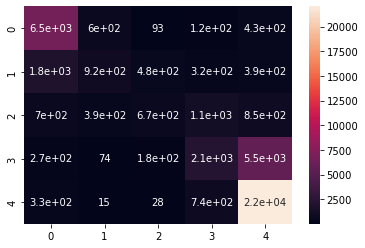

In [146]:
cf_matrix = confusion_matrix(y_test, nb_predict_y)
sns.heatmap(cf_matrix, annot=True)

# 5. Model Testing

In [150]:
# Prediction example
print('Actual Rating:', df.iloc[652]["stars"])
new_text = [df.iloc[652]["text_fix"]]
print('Review: ', new_text[0])
text_features = tfidf_vect.transform(new_text)
nbPredict = nbModel.predict(text_features)
rfPredict = rfModel.predict(text_features)
print('-------------------------------------------------------')
print('Naive Bayes Prediction: ', nbPredict[0])
print('Random Forest Prediction: ', rfPredict[0])

Actual Rating: 5.0
Review:  seriously the best breakfast i have had in a long time it is pricey but everything here in sb is breakfast bun, choc croissant and the yogurt dear jesus excellent cappuccino as well go there now
-------------------------------------------------------
Naive Bayes Prediction:  5.0
Random Forest Prediction:  5.0
